In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from astropy.table import Table

# File reading
import linecache

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
#%matplotlib notebook
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{bm} \usepackage{physics}']
%config InlineBackend.figure_format = 'retina' # For high quality figures
%load_ext autoreload
%autoreload 2

## Load the magnitudes and colors

In [2]:
data_folder = "data-2019-09-23-nickel-joey-anne"

In [3]:
ngc6819_v_mags     = np.load(os.path.join(data_folder, 'color_and_mag_results/ngc6819_v_mags.npy'))
ngc6819_b_mags     = np.load(os.path.join(data_folder, 'color_and_mag_results/ngc6819_b_mags.npy'))
ngc6819_b_minus_v  = np.load(os.path.join(data_folder, 'color_and_mag_results/ngc6819_b_minus_v.npy'))
ngc6819_abs_v_mags = np.load(os.path.join(data_folder, 'color_and_mag_results/ngc6819_abs_v_mags.npy'))

## Make a color magnitude diagram and a HR-Diagram

In [4]:
def plot(x, y, xlabel, ylabel, n_text_coords, xlim=None, fname=None):
    
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(x, y, '.', alpha=0.3)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(labelsize=14)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    
    ax.set_title('NGC 6819', size=14)
    
    x_text, y_text = n_text_coords
    ax.text(x_text, y_text, 'N = {}'.format(x.shape[0]), fontsize=12)

    plt.gca().invert_yaxis()
    fig.tight_layout()
    
    if fname is not None:
        fname = os.path.join('figures', fname)
        fig.savefig(os.path.join(data_folder, fname))
    
    plt.show()

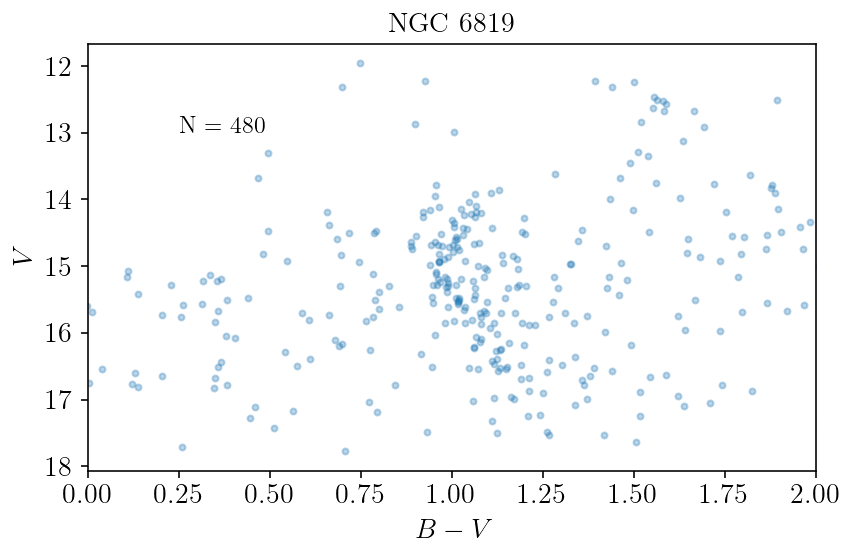

In [5]:
plot(ngc6819_b_minus_v, ngc6819_v_mags, r'$B - V$', r'$V$', (.25, 13.), xlim=(0., 2.))#, fname='cmd_zoomed.pdf')

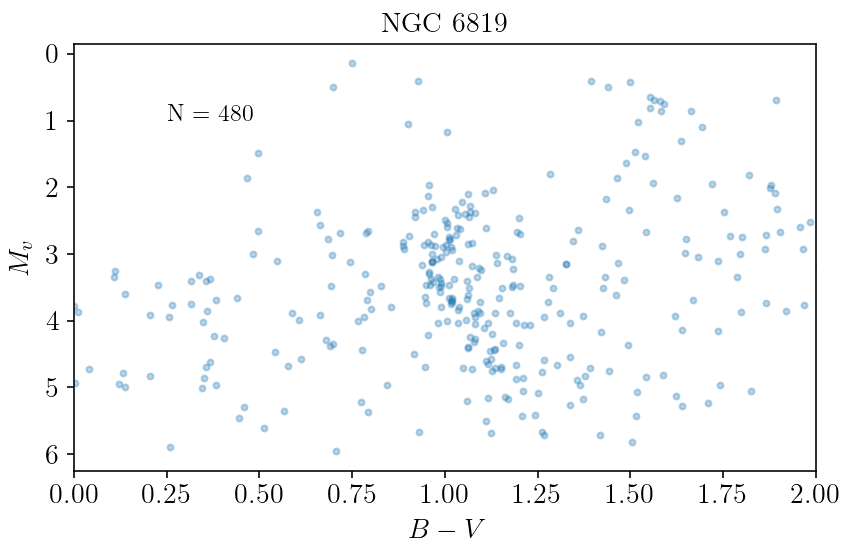

In [6]:
plot(ngc6819_b_minus_v, ngc6819_abs_v_mags, r'$B - V$', r'$M_v$', (0.25, 1.), xlim=(0., 2.))#, fname='hr_zoomed.pdf')

## Load the isochrones table as a DataFrame

From: http://stev.oapd.inaf.it/cgi-bin/cmd_3.3

Table filenames: 
    - iso_table_yearStart_yearEnd_step_Gyr.txt
    - isochrones/iso_table_1_10_1_Gyr.txt
    - isochrones/iso_table_1_4_0.5_Gyr.txt
    - isochrones/iso_table_0.1_100_1_Gyr.txt

In [33]:
isochrone_fname = os.path.join(data_folder, 'isochrones/iso_table_1_4_0.5_Gyr.txt')
column_names    = linecache.getline(isochrone_fname, 12).split()[1:]

iso_df = pd.read_csv(isochrone_fname, skiprows=12, sep=' ', header=None, skipinitialspace=True, comment='#')
iso_df.columns = column_names

### Split into several dfs based on logAge

In [34]:
logAge_list = np.unique(iso_df['logAge'])
iso_df_age_list = []

for logAge in logAge_list:
    iso_df_age_list.append(iso_df.loc[iso_df.logAge == logAge])

## Add B - V as a column to each of the isochrone dfs

In [35]:
for df in iso_df_age_list:
    b_minus_v = df.loc[:, 'Bmag'].values - df.loc[:, 'Vmag'].values
    df['Bmag-Vmag'] = b_minus_v
    
# Ignore this annoying warning from Pandas for now

/Users/josephmurphy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Plot the isochrones over the real color magnitude diagram to infer cluster age

In [44]:
def plot_with_isochrones(x, y, logAge_list, isochrone_list, xlim=None, fname=None):
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    # Plot the isochrones
    n_iso = len(isochrone_list)
    iso_cmap = plt.get_cmap('magma', n_iso)
    for i in range(len(isochrone_list)):
        iso_df = isochrone_list[i]
        
        # [:-1] slicing gets rid of some weird data point at the end of the values array
        ax.plot(iso_df.loc[:, 'Bmag-Vmag'].values[:-1], iso_df.loc[:, 'Vmag'].values[:-1], '.', 
                color=iso_cmap(i))
    
    # Isochrone colobar
    age_list = 10**np.array(logAge_list) * 1e-9 # Ages in Gyr
    norm = mpl.colors.Normalize(vmin=min(age_list), vmax=max(age_list))
    sm   = plt.cm.ScalarMappable(cmap=iso_cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=age_list)
    cbar.ax.yaxis.set_ticks([], minor=True) # Weird matplotlib bug fix needs this line
    cbar.ax.set_yticklabels(['{:.3f}'.format(age) for age in age_list], fontsize=12)
    cbar.ax.set_ylabel('Age (Gyr)', rotation=270, labelpad=18, fontsize=14)
    
    # Overplot the cluster data
    ax.plot(x, y, '.', alpha=0.3)
    ax.text(0.25, 13., 'N = {}'.format(x.shape[0]), fontsize=12)
    
    # Figure housekeeping
    ax.set_xlabel(r"$B - V$", fontsize=14)
    ax.set_ylabel(r"$V$", fontsize=14)
    ax.tick_params(labelsize=14)
    
    ax.set_ylim((12, 18))
    
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_title('NGC 6819', size=14)
    
    plt.gca().invert_yaxis()
    fig.tight_layout()
    
    # Save figure if filename specified
    if fname is not None:
        fname = os.path.join('figures', fname)
        fig.savefig(os.path.join(data_folder, fname))
    
    # Display
    plt.show()

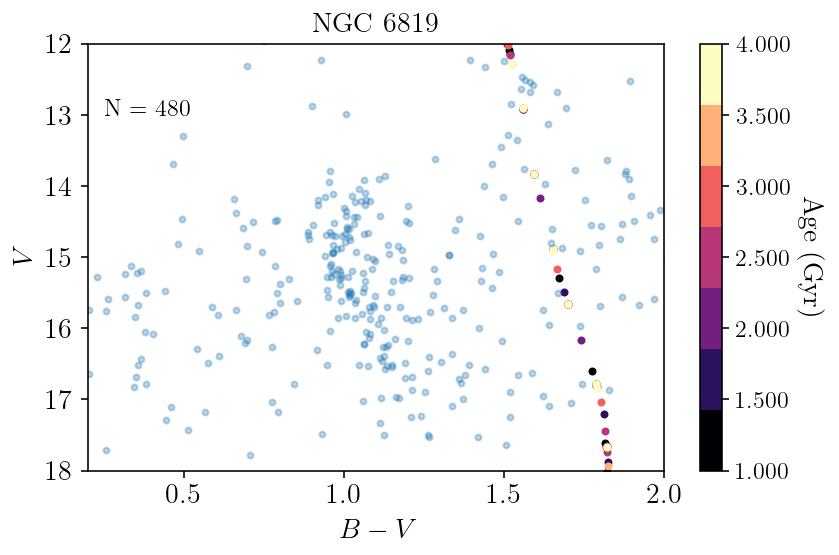

In [45]:
plot_with_isochrones(ngc6819_b_minus_v, ngc6819_v_mags, logAge_list, iso_df_age_list, xlim=(0.2, 2))